In [10]:
import re
import os
import pandas as pd
import itertools
import scipy
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import directed_hausdorff, cdist
from scipy.optimize import minimize
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

In [11]:
def get_cif(AA_filename):

    pattern = r'[0-9]'
    AA_elements = []
    AA_coords = []
    
    AA_filepath = os.path.join(AA_dir, AA_filename)
    
    with open(AA_filepath, "r") as f:
        for i, line in enumerate(f):
            line_ = line.strip().split()
            try:
                if len(line_) == 21:
                    # print(line_)
                    ele, x, y, z = line_[1], line_[15], line_[16], line_[17]
                    point = (float(x), float(y), float(z))
                    AA_elements.append(re.sub(pattern, '', ele))
                    AA_coords.append(point)
            except:
                continue
                # print(line.strip().split())
                
    AA_coords = np.array(AA_coords)
    AA_df = pd.DataFrame(columns=['ATOM', 'x', 'y', 'z'])
    AA_df[['x', 'y', 'z']] = AA_coords
    AA_df.index = AA_elements
    ele1 = np.array([np.array(AA_df.index)[ii][0] for ii in range(len(AA_df.index))])
    AA_df_noh = AA_df.loc[ele1 != 'H']
    
    return AA_df, AA_df_noh, ele1

In [12]:
def osipov_whole(coord):
    n = 2
    m = 1
    
    N = len(coord)
    
    if N >= 4:
        P = np.array(list(itertools.permutations(np.arange(N), 4))) # Get permutations
        
        coords_P = coord[P]
        r = coords_P - np.roll(coords_P, -1, axis=1)
        r[:, 3] = -r[:, 3]
        r_mag = np.linalg.norm(r, axis=-1)
    
        cross_vecs = np.cross(r[:, 0], r[:, 2])
    
        G_p_up = np.einsum('ij,ij->i', cross_vecs, r[:, 3]) * np.einsum('ij,ij->i', r[:, 0], r[:, 1]) * np.einsum('ij,ij->i', r[:, 1], r[:, 2])
        G_p_down = np.power(np.prod(r_mag[:,0:3], axis=-1), n) * np.power(r_mag[:, 3], m)
        
        
        G_p = (1 / 3) * np.sum(G_p_up / G_p_down)
    
        G_os = (24)/(N ** 4) *  G_p
        
    else:
        G_os = 0

    return G_os

In [17]:
def min_haus(degs, L, D):
    
    x,y,z,a,b,c = degs   
    
    r = R.from_euler('xyz', [a,b,c])
    D = r.apply(D)
    
    D += [x,y,z]
    haus, _, _ = directed_hausdorff(L, D)
    
    return haus

def haus_opt(x0, L, D):

    res = minimize(min_haus, x0, method='SLSQP', args=(L,D), options={'ftol': 1e-3, 'disp': False})

    return res['fun'], res['x']

def hcm(L):
    D = -L
    perm = product(np.linspace(-np.pi, np.pi, 24), repeat=3) #from -pi to pi rads, 24 even groups in between them
    inits_abc = np.array([i for i in perm])
    # iter_xyz = product(np.linspace(-np.max(cdist(c1_xyz, c1_xyz)) /50, np.max(cdist(c1_xyz, c1_xyz)) /50, 3), repeat=3)
    # inits_xyz = np.array([i for i in iter_xyz])
    inits_xyz = np.zeros([1,3])
    inits = np.append(np.tile(inits_xyz, [len(inits_abc), 1]), np.repeat(inits_abc, len(inits_xyz), axis=0), axis=1)
    num_cores = multiprocessing.cpu_count()
    output = Parallel(n_jobs=num_cores)(delayed(haus_opt)(i, L, D) for i in inits)
    values = [_[0] for _ in output]
    return min(values) / np.max(cdist(L,L))

In [18]:
AA_dir = os.path.join(os.getcwd(), 'AA_CIF')

In [19]:
AA_filename = os.listdir(AA_dir)[0]
AA_df, AA_df_noh, ele1 = get_cif(os.path.join(AA_dir, AA_filename))
coords = AA_df_noh[['x', 'y', 'z']].to_numpy()

In [20]:
AA_name = []
OPD = []
HCM = []
sizes = []
for AA_filename in os.listdir(AA_dir):
    AA_name.append((AA_filename[0:3]))
    AA_df, AA_df_noh, ele1 = get_cif(os.path.join(AA_dir, AA_filename))
    coords = AA_df_noh[['x', 'y', 'z']].to_numpy()
    sizes.append(np.max(cdist(coords, coords)))
    OPD.append(osipov_whole(coords))
    HCM.append(hcm(coords))

In [21]:
colors = np.repeat('#00274C', len(AA_name))

In [22]:
chiral_zeros_cut = np.array(AA_name)[np.where(np.abs(OPD) < 0.0025)]
chiral_zeros_cut = chiral_zeros_cut[chiral_zeros_cut != 'GLY']
zeros_ = [np.where(np.array(AA_name)==_)[0][0] for _ in chiral_zeros_cut]
colors[zeros_] = 'r'

In [23]:
aa_hcm = HCM
aa_opd = OPD

In [24]:
offsetx = np.zeros(len(HCM))
offsety = np.zeros(len(HCM))

In [25]:
offsetx += 4
offsety -= 3

In [26]:
offsetx[2] = -2
offsety[2] = +3

offsetx[4] = -7
offsety[4] = +3

offsety[6] = -5

offsety[3] = -1
offsety[8] = -9

offsetx[10] = 0
offsety[10] = -10

offsety[11] = -7

offsetx[18] = -15
offsety[18] = +4

offsetx[1] = -2
offsety[1] = -10

offsety[16] = +3
offsetx[16] = -15

offsetx[12] = -25

In [27]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = np.repeat(cycle[0], len(AA_name))
colors[zeros_] = 'r'

In [10]:
opds = np.squeeze(pd.read_csv(os.path.join(int_path,'opds_CA.csv')).to_numpy())
hcms = np.squeeze(pd.read_csv(os.path.join(int_path,'hcms_CA.csv')).to_numpy())
# hcms = np.squeeze(pd.read_csv(os.path.join(int_path,'hcm55.csv')).to_numpy())
zeros_idx = [11, 27, 64, 77, 98, 151, 181, 189, 191, 200, 210, 243, 253]
opds = np.delete(opds, zeros_idx, axis=0)
hcms = np.delete(hcms, zeros_idx, axis=0)

In [11]:
hcm_corr = scipy.stats.pearsonr(hcms[:,0], hcms[:,1])
opd_corr = scipy.stats.pearsonr(opds[:,0], opds[:,1])

In [14]:
hcm_path = os.path.join(os.getcwd(), 'chirality_neighborhood_hcm')
opd_path = os.path.join(os.getcwd(), 'chirality_neighborhood_opd')

In [15]:
hcm_filelist = [_ for _ in os.listdir(hcm_path) if len(_.split('_')[-1]) == 1]
opd_filelist = [_ for _ in os.listdir(opd_path) if len(_.split('_')[-1]) == 1]

In [43]:
scale3 = [_ for _ in both_list if _.split('_')[-1] == '3']
scale4 = [_ for _ in both_list if _.split('_')[-1] == '4']
scale5 = [_ for _ in both_list if _.split('_')[-1] == '5']
scale6 = [_ for _ in both_list if _.split('_')[-1] == '6']
scale8 = [_ for _ in both_list if _.split('_')[-1] == '8']

In [44]:
inall = [_.split('_')[0:2] for _ in scale8]

In [45]:
scale3 = [_ for _ in scale3 if _.split('_')[0:2] in inall]
scale4 = [_ for _ in scale4 if _.split('_')[0:2] in inall]
scale5 = [_ for _ in scale5 if _.split('_')[0:2] in inall]
scale6 = [_ for _ in scale6 if _.split('_')[0:2] in inall]
scale8 = [_ for _ in scale8 if _.split('_')[0:2] in inall]

In [46]:
hcms = [[] for _ in range(5)]
opds = [[] for _ in range(5)]

for filename in scale3:
    opd = pd.read_csv(os.path.join(opd_path, filename))
    hcm = pd.read_csv(os.path.join(hcm_path, filename))
    opds[0] = np.append(opds[0], opd['3'].to_numpy())
    hcms[0] = np.append(hcms[0], hcm['3'].to_numpy())
for filename in scale4:
    opd = pd.read_csv(os.path.join(opd_path, filename))
    hcm = pd.read_csv(os.path.join(hcm_path, filename))
    opds[1] = np.append(opds[1], opd['4'].to_numpy())
    hcms[1] = np.append(hcms[1], hcm['4'].to_numpy())
for filename in scale5:
    opd = pd.read_csv(os.path.join(opd_path, filename))
    hcm = pd.read_csv(os.path.join(hcm_path, filename))
    opds[2] = np.append(opds[2], opd['5'].to_numpy())
    hcms[2] = np.append(hcms[2], hcm['5'].to_numpy())
for filename in scale6:
    opd = pd.read_csv(os.path.join(opd_path, filename))
    hcm = pd.read_csv(os.path.join(hcm_path, filename))
    opds[3] = np.append(opds[3], opd['6'].to_numpy())
    hcms[3] = np.append(hcms[3], hcm['6'].to_numpy())
for filename in scale8:
    opd = pd.read_csv(os.path.join(opd_path, filename))
    hcm = pd.read_csv(os.path.join(hcm_path, filename))
    opds[4] = np.append(opds[4], opd['8'].to_numpy())
    hcms[4] = np.append(hcms[4], hcm['8'].to_numpy())

In [47]:
hcms = np.array(hcms)
opds = np.array(opds)

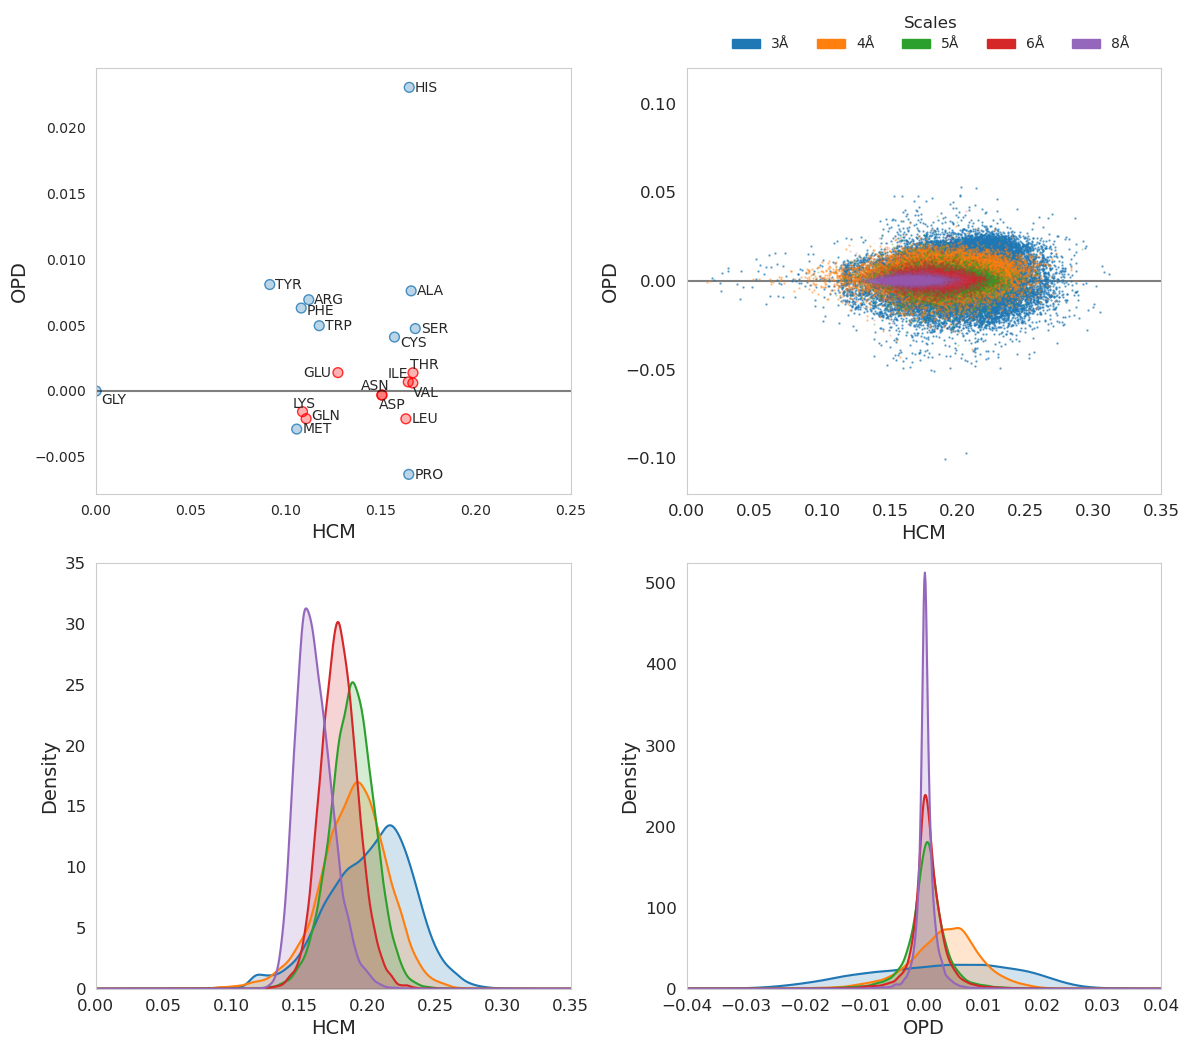

In [87]:
fig = plt.figure(figsize=(12,10))
fsize=14
size = 0.5
alpha = 0.2

ax = fig.add_subplot(2, 2, 1)
ax.scatter(aa_hcm, aa_opd, facecolor=(colors, 0.3), edgecolor=(colors, 0.8), s=50, marker='o') #,
plt.axhline(y=0, xmin=0,xmax=1, c='k', linestyle='-', alpha=0.5, zorder=1)
for i, txt in enumerate(AA_name):

    ax.annotate(txt,(aa_hcm[i], aa_opd[i]),xytext=(offsetx[i], offsety[i]), textcoords='offset points')

ax.grid(False)
ax.set_xlabel('HCM', fontsize=fsize)
ax.set_ylabel('OPD', fontsize=fsize)
plt.xlim(0.0, 0.25)


cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax0 = fig.add_subplot(2, 2, 2)

plt.axhline(y=0, xmin=0,xmax=1, c='k', linestyle='-', alpha=0.5, zorder=1)
ax0.scatter(hcms[0], opds[0], s=size, c=cycle[0], alpha=alpha*3, edgecolors=None)
ax0.scatter(hcms[1], opds[1], s=size, c=cycle[1], alpha=alpha*2, edgecolors=None)
ax0.scatter(hcms[2], opds[2], s=size, c=cycle[2], alpha=alpha*1.2, edgecolors=None)
ax0.scatter(hcms[3], opds[3], s=size, c=cycle[3], alpha=alpha*0.8, edgecolors=None)
ax0.scatter(hcms[4], opds[4], s=size, c=cycle[4], alpha=alpha*0.3, edgecolors=None)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.tick_params(axis='both', which='minor', labelsize=12)

ax0.grid(False)
ax0.set_xlim(0,0.35)
ax0.set_ylim(-0.12, 0.12)
ax0.set_xlabel('HCM', fontsize=fsize)
ax0.set_ylabel('OPD', fontsize=fsize)

ax2 = fig.add_subplot(2, 2, 3)
x_range = np.linspace(0, 0.35, 1000)
for i, data in enumerate(hcms):
    kde = gaussian_kde(data)
    ax2.plot(x_range, kde(x_range))
    ax2.fill_between(x_range, kde(x_range), color=cycle[i], alpha=0.2)
ax2.set_xlim(0,0.35)
ax2.set_ylim(0,35)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax2.set_xlabel('HCM', fontsize=fsize)
ax2.set_ylabel('Density', fontsize=fsize)

ax3 = fig.add_subplot(2, 2, 4)
x_range = np.linspace(-0.05,0.05, 1000)
for i, data in enumerate(opds):
    kde = gaussian_kde(data)
    ax3.plot(x_range, kde(x_range))
    ax3.fill_between(x_range, kde(x_range), color=cycle[i], alpha=0.2)
ax3.set_xlim(-0.04,0.04)
ax3.set_ylim(0,525)
ax3.grid(False)
ax3.set_xlabel('OPD', fontsize=fsize)
ax3.set_ylabel('Density', fontsize=fsize)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='minor', labelsize=12)

scale3_patch = mpatches.Patch(color=cycle[0], label=u'3\u212B')
scale4_patch = mpatches.Patch(color=cycle[1], label=u'4\u212B')
scale5_patch = mpatches.Patch(color=cycle[2], label=u'5\u212B')
scale6_patch = mpatches.Patch(color=cycle[3], label=u'6\u212B')
scale8_patch = mpatches.Patch(color=cycle[4], label=u'8\u212B')

fig.legend(title='Scales',
           ncol=8,
           handles=[scale3_patch,scale4_patch, scale5_patch, scale6_patch, scale8_patch],
           loc = "upper center",
           bbox_to_anchor = (0.78, 1.05),
           bbox_transform = plt.gcf().transFigure,
           frameon=False,
           title_fontsize=fsize-2
           )

plt.tight_layout()
plt.savefig('scales.png', dpi=600)
plt.show()